<a href="https://colab.research.google.com/github/zkhan04/ai-experiments/blob/master/audio-ai/Audio_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
BASEDIR = '/content/gdrive/My Drive/Colab Data/audio'

In [ ]:
featuresdf = pd.read_pickle(os.path.join(BASEDIR, 'zayd_data.pkl'))

In [ ]:
featuresdf.shape

(199, 2)

In [ ]:
featuresdf.head()

,feature,class_label
0,"[-349.6761883061811, 77.97523127033531, -39.60...",true
1,"[-162.9719763103223, 14.484394950908994, -8.11...",true
2,"[-123.59541613826386, 14.752998048912946, -7.2...",true
3,"[-224.82055260907148, 51.0820508547996, -3.274...",true
4,"[-157.86453794559563, 35.08948012718332, -10.6...",true


In [ ]:
import torch

In [ ]:
# Get dataset ready for training
# Split the dataset into 70% train data and 30% test data

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Create a custom dataset. This audio dataset takes in a Pandas dataframe 
# as an input. The first element of the Pandas dataframe is an array of 40 
# elements that we generated using librosa MFCC function on each of our audio
# files. The second column of the dataframe is a label - true or false
class AudioDataSet(Dataset):
  def __init__(self, df):
    self.audio_df = df

  def __len__(self):
    return self.audio_df.shape[0]

  def __getitem__(self, idx):
    audio_vector = torch.FloatTensor(self.audio_df.iloc[idx,0])
    audio_label = self.audio_df.iloc[idx,1]
    if audio_label == 'true':
      audio_label = torch.tensor(1)
    else:
      audio_label = torch.tensor(0)

    return audio_vector, audio_label

In [ ]:
# Generate the audio dataset and split it into 70/30 train and validation
# dataset
audio_dataset = AudioDataSet(featuresdf)
train_percent = 0.7
train_len = int(len(audio_dataset) * train_percent)
valid_len = len(audio_dataset) - train_len
train_set, validation_set = torch.utils.data.random_split(audio_dataset,
                                                          [train_len, valid_len])

In [ ]:
# Create the train and test loader
trainloader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0)
testloader = DataLoader(validation_set, batch_size=4, shuffle=True, num_workers=0)

In [ ]:
# Check one batch from train loader
dataiter = iter(trainloader)
audio, label = dataiter.next()
print(audio)
print(label)
print(audio.shape)

tensor([[-5.1147e+02,  9.9563e+01,  2.3002e+00,  3.8539e+01,  3.4623e+00,
          2.7156e+01, -1.4997e+00,  2.2119e+01, -5.9600e+00,  1.4949e+01,
         -7.0596e+00,  1.3390e+01, -6.1095e+00,  1.0134e+01, -5.6442e+00,
          8.3926e+00, -4.7463e+00,  6.7568e+00, -2.9155e+00,  5.1840e+00,
         -3.3077e+00,  6.4453e+00,  6.2366e-01,  9.1341e+00,  2.3456e+00,
          5.3539e+00, -9.7854e-02,  4.0854e+00,  1.0709e+00,  3.3138e+00,
         -2.2009e+00,  4.2485e-01, -3.7324e+00, -1.1608e+00, -2.3590e+00,
         -6.0575e-01, -1.7669e+00,  9.2922e-01, -8.4145e-01,  2.7149e-01],
        [-3.4740e+02,  2.0077e+01, -6.6918e+00,  1.5563e+01,  6.4238e+00,
          3.9447e+01,  2.9548e+00,  1.2005e+01, -1.7327e+01,  2.1246e+01,
         -8.3279e+00,  9.7619e+00, -7.8662e+00,  4.5501e+00, -1.3450e+00,
          1.5988e+01, -4.6837e+00,  7.4792e+00, -7.8667e+00,  8.9616e+00,
         -1.7854e+00,  7.7351e+00,  1.1502e+00,  5.4582e+00, -2.3187e+00,
          8.0171e+00, -1.0167e+00,  3

In [ ]:
from torch import nn
import torch.nn.functional as F
from torch import optim

In [ ]:
# Our network has 40 inputs and 2 outputs
# We will create two hidden layers of size 256 and 128
class AudioNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    # Create first layer
    self.fc1 = nn.Linear(40, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128,2)

    # Dropout module with 0.2 drop probability
    self.dropout = nn.Dropout(p = 0.2)

  def forward(self,x):
      # Hidden layer 1 with sigmoid activation
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout(x)
      

      # Hidden layer 2 with sigmoid activation
      x = self.fc2(x)
      x = F.relu(x)
      x = self.dropout(x)

      # Output layer 3 with log softmax activation
      x = self.fc3(x)
      x = F.log_softmax(x, dim=1)

      return x

In [ ]:
model = AudioNetwork()

In [ ]:
model

AudioNetwork(
  (fc1): Linear(in_features=40, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

dataiter = iter(trainloader)
audio, label = dataiter.next()

# Forward Pass
log_ps = model(audio)
ps = torch.exp(log_ps)
print(label)
print(ps.topk(1))

# Calculate Loss
loss = criterion(log_ps, label)
print(loss)

# Gradient descent
# loss.backward computes derivative (dloss/dx)
loss.backward()
optimizer.step()

# Clear Gradients prior to a new pass
optimizer.zero_grad()

# Forward Pass 
log_ps = model(audio)
ps = torch.exp(log_ps)
print(label)
print(ps.topk(1))

loss = criterion(log_ps, label)
print(loss)

loss.backward()
optimizer.step()


tensor([0, 0, 1, 1])
torch.return_types.topk(
values=tensor([[0.9959],
        [0.9993],
        [0.5074],
        [0.9924]], grad_fn=<TopkBackward>),
indices=tensor([[1],
        [1],
        [1],
        [0]]))
tensor(4.5904, grad_fn=<NllLossBackward>)
tensor([0, 0, 1, 1])
torch.return_types.topk(
values=tensor([[0.9307],
        [0.9817],
        [0.7589],
        [0.9615]], grad_fn=<TopkBackward>),
indices=tensor([[0],
        [0],
        [0],
        [1]]))
tensor(0.3881, grad_fn=<NllLossBackward>)


In [ ]:
model = AudioNetwork()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.005)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 25
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for audios, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(audios)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/25..  Training Loss: 2.437..  Test Loss: 1.283..  Test Accuracy: 0.700
Epoch: 2/25..  Training Loss: 1.013..  Test Loss: 2.444..  Test Accuracy: 0.700
Epoch: 3/25..  Training Loss: 0.943..  Test Loss: 1.463..  Test Accuracy: 0.700
Epoch: 4/25..  Training Loss: 0.837..  Test Loss: 0.290..  Test Accuracy: 0.867
Epoch: 5/25..  Training Loss: 0.647..  Test Loss: 0.539..  Test Accuracy: 0.833
Epoch: 6/25..  Training Loss: 0.407..  Test Loss: 0.423..  Test Accuracy: 0.817
Epoch: 7/25..  Training Loss: 0.401..  Test Loss: 0.399..  Test Accuracy: 0.800
Epoch: 8/25..  Training Loss: 0.504..  Test Loss: 0.306..  Test Accuracy: 0.867
Epoch: 9/25..  Training Loss: 0.391..  Test Loss: 0.408..  Test Accuracy: 0.850
Epoch: 10/25..  Training Loss: 0.340..  Test Loss: 0.318..  Test Accuracy: 0.867
Epoch: 11/25..  Training Loss: 0.323..  Test Loss: 0.460..  Test Accuracy: 0.900
Epoch: 12/25..  Training Loss: 0.319..  Test Loss: 0.329..  Test Accuracy: 0.867
Epoch: 13/25..  Training Loss: 0.286.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

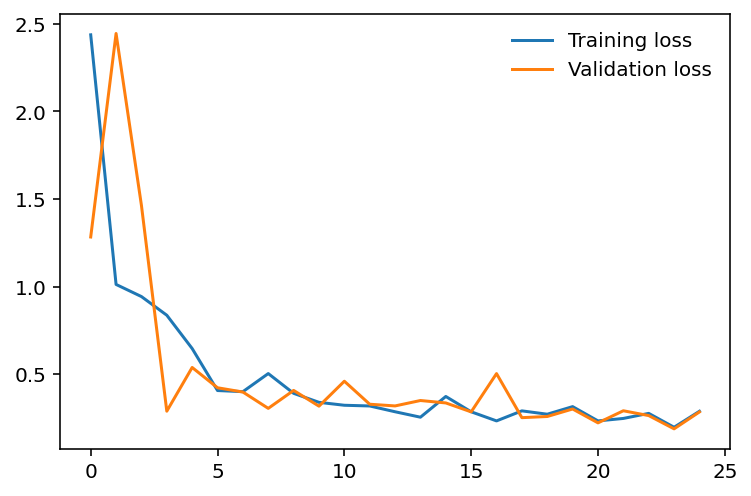

In [ ]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(test_losses, label = 'Validation loss')
plt.legend(frameon = False)

In [ ]:
dataiter = iter(testloader)
audio, label = dataiter.next()

with torch.no_grad():
  log_ps = model.forward(audio)

ps = torch.exp(log_ps)
print(label)
print(ps.topk(1))

tensor([0, 1, 0, 1])
torch.return_types.topk(
values=tensor([[0.9977],
        [0.8387],
        [0.9992],
        [0.9726]]),
indices=tensor([[0],
        [0],
        [0],
        [1]]))


In [ ]:
torch.save(model.state_dict(), os.path.join(BASEDIR, 'zayd_model.pk1'))

In [ ]:
model2 = AudioNetwork()

In [ ]:
state_dict = torch.load(os.path.join(BASEDIR, 'zayd_model.pk1'))

In [ ]:
model2.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
dataiter = iter(testloader)
audio, label = dataiter.next()

with torch.no_grad():
  log_ps = model2.forward(audio)

ps = torch.exp(log_ps)
print(label)
print(ps.topk(1))

tensor([0, 1, 0, 1])
torch.return_types.topk(
values=tensor([[0.9979],
        [0.9607],
        [0.9944],
        [1.0000]]),
indices=tensor([[0],
        [1],
        [0],
        [1]]))
